# GetContacts flareplots, fingerprints and heatmaps

In [1]:
import pandas as pd
# import sys
# sys.path.append("./")
import freq

# Preparation
## Load the data

At first all frequencies are calculated using **GetContacts**.
More information can be found on their github page:
    https://getcontacts.github.io/.

For the calculation only the interaction type was specified but no selection. The selection will be chosen later on in this script.

In [2]:
all_freq_ab1 = freq.Frequency.from_tsv(
    filename = './wt_freq.tsv', 
    interaction = 'vdw', 
    name = 'Wildtype'
)

Here are some of the attributes of the `Frequency` instance shown.

In [3]:
all_freq_ab1.df

,res 1,number 1,res 2,number 2,contact_frequency
0,PRO,386,SER,163,0.583
1,PHE,385,SER,177,0.930
2,PHE,117,SER,351,0.265
3,TYR,317,TYR,92,0.965
4,PRO,342,SER,122,0.805
...,...,...,...,...,...
358,LYS,258,LYS,40,0.000
359,GLU,1,GLU,303,0.000
360,ILE,2,LEU,260,0.000
361,GLY,257,ILE,2,0.000


In [4]:
all_freq_ab1.interaction

'vdw'

In [5]:
all_freq_ab1.selection

In [6]:
all_freq_ab1.filename

'./wt_freq.tsv'

In [7]:
all_freq_ab1.info()

System:			Wildtype
                Interactiontype:	vdw
                Frequencies from:	./wt_freq.tsv


## Choose a selection

The `Frequency.select` method allows the selection of one or two ranges of residues. The method returns a new `Frequency` instance.

The first range of residues is passed as `(start_residue, end_residue)`. Optionally, a second range can be passed.

In [8]:
some_freq_ab1 = all_freq_ab1.select((0,215), (313,321))
some_freq_ab1.df.head()

,res 1,number 1,res 2,number 2,contact_frequency
3,TYR,317,TYR,92,0.965
5,LEU,47,TYR,318,0.885
22,TYR,318,TYR,50,0.937
26,PHE,319,TYR,37,0.973
29,ARG,97,ASP,316,0.555


Everything we have done so far can be repeated for a second datafile.

In [9]:
all_freq_ab2 = freq.Frequency.from_tsv(
    filename = './mt_freq.tsv', 
    interaction = 'vdw', 
    name = 'Mashup'
)
some_freq_ab2 = all_freq_ab2.select((0,215), (313,321))
some_freq_ab2.df.head()

,res 1,number 1,res 2,number 2,contact_frequency
0,PHE,319,TYR,36,0.496
1,GLN,55,TYR,318,0.664
3,ASP,320,GLN,55,0.234
10,TYR,318,TYR,49,0.690
15,GLN,89,PHE,319,0.033


In [10]:
some_freq_ab2.selection

((0, 215), (313, 321))

## Merge the data

The data is stored as a `pandas.DataFrame` and can be accessed using the `Frequency.df` attribute. This way **pandas** can be used to conveniently merge the data.

Here, all columns except the _contact_frequency_ are set as index and then merged using `pandas.concat`.

In [11]:
df_concat = pd.concat(
    [some_freq_ab1.df.set_index(keys=['res 1', 'number 1', 'res 2', 'number 2']),
    some_freq_ab2.df.set_index(keys=['res 1', 'number 1', 'res 2', 'number 2'])],
    keys = [some_freq_ab1.name, some_freq_ab2.name]
)
df_concat

contact_frequency
         res 1 number 1 res 2 number 2                   
Wildtype TYR   317      TYR   92                    0.965
         LEU   47       TYR   318                   0.885
         TYR   318      TYR   50                    0.937
         PHE   319      TYR   37                    0.973
         ARG   97       ASP   316                   0.555
...                                                   ...
Mashup   ASP   92       TYR   318                   0.002
         LEU   91       TRP   314                   0.000
         ASP   92       PHE   319                   0.000
         TRP   314      VAL   58                    0.000
         LYS   45       TRP   314                   0.002

[159 rows x 1 columns]

Now, the outermost indices _first_ and _second_ are unpacked into two columns with `pandas.unstack`.

In [12]:
merged_df = df_concat.unstack(level=-5, fill_value=0)
merged_df

contact_frequency       
                                       Wildtype Mashup
res 1 number 1 res 2 number 2                         
ALA   34       TYR   317                  0.000  0.008
                     318                  0.000  0.009
      35       TYR   317                  0.000  0.000
                     318                  0.183  0.000
      43       ASP   320                  0.000  0.000
...                                         ...    ...
TYR   318      TYR   37                   0.708  0.000
                     49                   0.000  0.690
                     50                   0.937  0.000
                     92                   0.575  0.000
               VAL   58                   0.000  0.006

[154 rows x 2 columns]

The data can be sorted as preferred.

In [13]:
# sorting by value
# merged_df.sort_values(by = [('contact_frequency', 'first'),
#                             ('contact_frequency', 'second')],
#                       ascending=False
#)

# sorting by residue number 
merged_df = merged_df.sort_index(level=['number 1', 'number 2'])
merged_df

contact_frequency       
                                       Wildtype Mashup
res 1 number 1 res 2 number 2                         
SER   30       TYR   317                  0.000  0.000
      31       TYR   317                  0.000  0.005
                     318                  0.000  0.002
      32       TYR   317                  0.004  0.000
LEU   33       TYR   318                  0.000  0.001
...                                         ...    ...
ASP   320      TYR   50                   0.000  0.000
               GLN   55                   0.000  0.234
               SER   56                   0.000  0.040
               GLY   57                   0.000  0.001
               THR   57                   0.000  0.000

[154 rows x 2 columns]

## Change the labels

For plotting with `heatmap` or `fingerprint` the dataframe may only have two index labels.
The indices can be formated as preferred.

Here, the dictionary `three2one` can be used to convert the amino acid three letter code to the one letter code.

To remove the label on the x_axis the column label _contact_frequency_ has to be removed.

In [14]:
# example on how to create labels using one_letter_code
pd.MultiIndex.from_arrays(
    zip(*[(f"{freq.three2one[res1]}{num1:03}", f"{freq.three2one[res2]}{num2:03}") for res1, num1, res2, num2 in merged_df.index])
)

MultiIndex([('S030', 'Y317'),
            ('S031', 'Y317'),
            ('S031', 'Y318'),
            ('S032', 'Y317'),
            ('L033', 'Y318'),
            ('A034', 'Y317'),
            ('A034', 'Y318'),
            ('A035', 'Y317'),
            ('A035', 'Y318'),
            ('K042', 'Y321'),
            ...
            ('D320', 'Y036'),
            ('D320', 'P044'),
            ('D320', 'K045'),
            ('D320', 'L046'),
            ('D320', 'L047'),
            ('D320', 'Y050'),
            ('D320', 'Q055'),
            ('D320', 'S056'),
            ('D320', 'G057'),
            ('D320', 'T057')],
           length=154)

In [15]:
# simple example on how to 'merge' the labels
merged_df.index = pd.MultiIndex.from_arrays(
    zip(*[(f"{res1}{num1:03}", f"{res2}{num2:03}") for res1, num1, res2, num2 in merged_df.index])
)
# removing the 'conact_frequency' label
merged_df.columns = [name for _, name in merged_df.columns]

merged_df

Wildtype  Mashup
SER030 TYR317     0.000   0.000
SER031 TYR317     0.000   0.005
       TYR318     0.000   0.002
SER032 TYR317     0.004   0.000
LEU033 TYR318     0.000   0.001
...                 ...     ...
ASP320 TYR050     0.000   0.000
       GLN055     0.000   0.234
       SER056     0.000   0.040
       GLY057     0.000   0.001
       THR057     0.000   0.000

[154 rows x 2 columns]

## Apply a cutoff

All contact_frequencies with a frequency lower than the cutoff are discarded for plotting.

In [16]:
CUTOFF = 0.6

In [17]:
#absolute cutoff
merged_df[(merged_df > CUTOFF).any(axis=1)]

Wildtype  Mashup
LEU046 TYR318     0.000   0.627
LEU047 TYR318     0.885   0.001
GLN055 TYR318     0.000   0.664
ARG097 ASP313     0.673   0.000
       TYR317     0.738   0.000
       PHE319     0.632   0.000
TYR317 TYR092     0.965   0.000
TYR318 TYR037     0.708   0.000
       TYR049     0.000   0.690
       TYR050     0.937   0.000
PHE319 TYR037     0.973   0.000
       PHE099     0.693   0.028

In [18]:
# relative cutoff
merged_df[abs(merged_df[some_freq_ab1.name]-merged_df[some_freq_ab2.name]) > CUTOFF]

Wildtype  Mashup
LEU046 TYR318     0.000   0.627
LEU047 TYR318     0.885   0.001
GLN055 TYR318     0.000   0.664
ARG097 ASP313     0.673   0.000
       TYR317     0.738   0.000
       PHE319     0.632   0.000
TYR317 TYR092     0.965   0.000
TYR318 TYR037     0.708   0.000
       TYR049     0.000   0.690
       TYR050     0.937   0.000
PHE319 TYR037     0.973   0.000
       PHE099     0.693   0.028

In [19]:
# relative if more than two systems have been merged
merged_cut_df = merged_df[merged_df.max(axis=1)-merged_df.min(axis=1) > CUTOFF]
merged_cut_df

Wildtype  Mashup
LEU046 TYR318     0.000   0.627
LEU047 TYR318     0.885   0.001
GLN055 TYR318     0.000   0.664
ARG097 ASP313     0.673   0.000
       TYR317     0.738   0.000
       PHE319     0.632   0.000
TYR317 TYR092     0.965   0.000
TYR318 TYR037     0.708   0.000
       TYR049     0.000   0.690
       TYR050     0.937   0.000
PHE319 TYR037     0.973   0.000
       PHE099     0.693   0.028

# Visualize the frequencies

## Flareplots

To visualize a single systems contacts the method `Frequency.flare` can be used. 

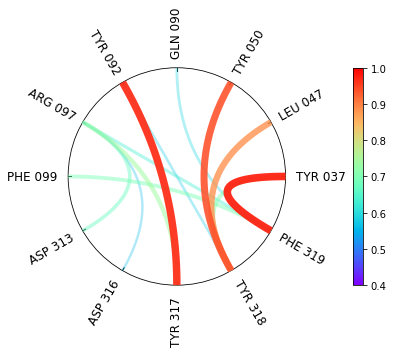

In [20]:
fig = some_freq_ab1.flare(cmap='rainbow', fontsize=12, linewidth=8, one_letter=False, cbar=True, cutoff=0.4)

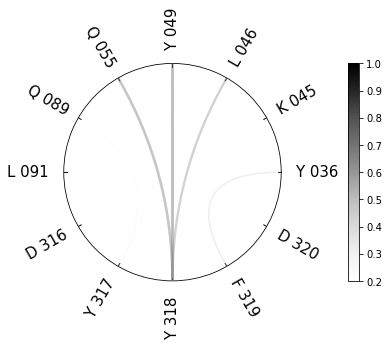

In [21]:
fig = some_freq_ab2.flare(cmap='Greys', fontsize=15, linewidth=6, cbar=True, cutoff=0.2)

## Fingerprints and heatmaps

The functions `fingerprint` and `heatmap` can be used to compare two systems.
`fingerprint` clusters the data internally using a hierarchical clustering, while `heatmap` plots the data in the same order as they appear in the DataFrame.

The labels in the plot match the indices of the DataFrame. To change the labels of the plot, the indices of the DataFrame have to be changed.

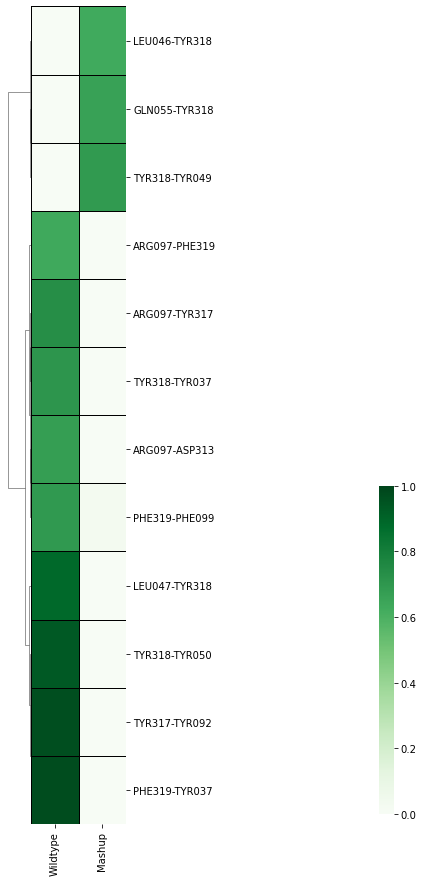

In [22]:
fig = freq.fingerprint(
data = merged_cut_df, 
    cmap = 'Greens',
    y_size = 2, cbar_pos=(2.6, 0.05, 0.1, 0.38) #(x, y, dx, dy)
)

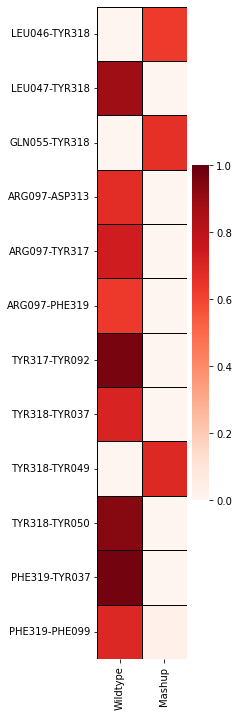

In [23]:
fig = freq.heatmap(
    data = merged_cut_df, 
    cmap = 'Reds', 
    y_size = 2,
)

# Compare more than two systems

Comparing more than two systems is easy. It is done exactly the same way as before.

In [24]:
some_freq_ab3 = some_freq_ab2

In [25]:
# merging the data
df_concat = pd.concat(
    [
        some_freq_ab1.df.set_index(keys=['res 1', 'number 1', 'res 2', 'number 2']),
        some_freq_ab2.df.set_index(keys=['res 1', 'number 1', 'res 2', 'number 2']),
        some_freq_ab3.df.set_index(keys=['res 1', 'number 1', 'res 2', 'number 2'])
    ],
    keys = ['first', 'second', 'third']
)

# expand the 'contact_frequency' column so that the three systems are in seperate columns
merged_df = df_concat.unstack(level=-5, fill_value=0)

# sort the data
merged_df = merged_df.sort_index(level=['number 1', 'number 2'])

# changing the labels as preferred
merged_df.index = pd.MultiIndex.from_arrays(
    zip(*[(f"{res1}{num1:03}", f"{res2}{num2:03}") for res1, num1, res2, num2 in merged_df.index])
)
# removing 'contact_frequency' as a label for the plots
merged_df.columns = [name for _, name in merged_df.columns]

#applying a cutoff
CUTOFF = 0.6
merged_cut_df_expanded = merged_df[merged_df.max(axis=1)-merged_df.min(axis=1) > CUTOFF]
merged_cut_df_expanded

first  second  third
LEU046 TYR318  0.000   0.627  0.627
LEU047 TYR318  0.885   0.001  0.001
GLN055 TYR318  0.000   0.664  0.664
ARG097 ASP313  0.673   0.000  0.000
       TYR317  0.738   0.000  0.000
       PHE319  0.632   0.000  0.000
TYR317 TYR092  0.965   0.000  0.000
TYR318 TYR037  0.708   0.000  0.000
       TYR049  0.000   0.690  0.690
       TYR050  0.937   0.000  0.000
PHE319 TYR037  0.973   0.000  0.000
       PHE099  0.693   0.028  0.028

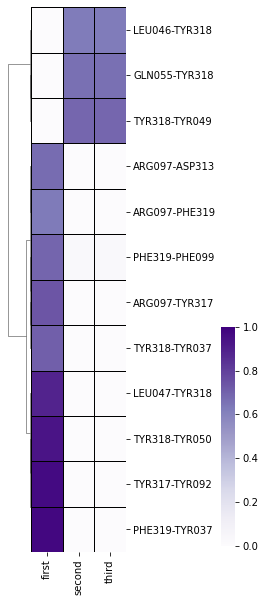

In [26]:
fig = freq.fingerprint(
    data = merged_cut_df_expanded, 
    cmap = 'Purples', 
    y_size = 2,  
)

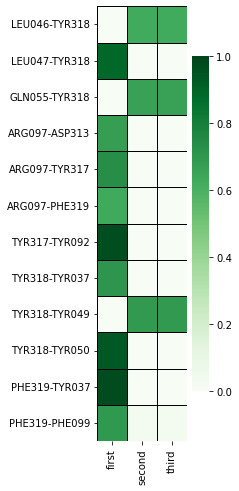

In [27]:
fig = freq.heatmap(
    data = merged_cut_df_expanded, 
    cmap = 'Greens', 
    y_size = 2,
)